<a href="https://colab.research.google.com/github/Hos96/Market-Basket/blob/main/Hossein_Akrami_Market_Basket_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hossein Akrami, Market basket analysis

In [1]:
!pip install pyspark==3.2.0
!pip install  mlxtend
!pip install wordcloud
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 14.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805891 sha256=3dc587b190a664df13e19e69de649fe28e42ed1095cfa820c7de629075b69921
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
import os

In [3]:
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName("MarketBasketAnalysis") \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "12g") \
    .getOrCreate()

In [4]:
import time
from datetime import datetime

# Defining a function to print time of running each block of code
def timing_info(start_time, step_name):
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    start_time_str = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
    print(f"{step_name} time: {int(minutes)}min {int(seconds)}s (started: {start_time_str})")

In [5]:
# Download from  Kaggle
os.environ['KAGGLE_USERNAME'] = "xxxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxxx"
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
100% 1.88G/1.88G [00:26<00:00, 140MB/s]
100% 1.88G/1.88G [00:26<00:00, 76.0MB/s]


In [6]:
# Unzipping the dataset
!unzip -q 1-3m-linkedin-jobs-and-skills-2024.zip
#Spark DataFrame
df = spark.read.option("header", "true").csv("job_skills.csv")

df.show(10)

+--------------------+--------------------+
|            job_link|          job_skills|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
|https://www.linke...|Applied Behavior ...|
|https://www.linke...|Electrical Engine...|
|https://www.linke...|Electrical Assemb...|
|https://www.linke...|Access Control, V...|
|https://www.linke...|Consultation, Sup...|
|https://www.linke...|Veterinary Recept...|
|https://www.linke...|Optical Inspectio...|
|https://www.linke...|HVAC, troubleshoo...|
+--------------------+--------------------+
only showing top 10 rows



In [7]:
print(df.head(10))

[Row(job_link='https://www.linkedin.com/jobs/view/housekeeper-i-pt-at-jacksonville-state-university-3802280436', job_skills='Building Custodial Services, Cleaning, Janitorial Services, Materials Handling, Housekeeping, Sanitation, Waste Management, Floor Maintenance, Equipment Maintenance, Safety Protocols, Communication Skills, Attention to Detail, Physical Strength, Experience in Housekeeping'), Row(job_link='https://www.linkedin.com/jobs/view/assistant-general-manager-huntington-4131-at-ruby-tuesday-3575032747', job_skills="Customer service, Restaurant management, Food safety, Training, Supervision, Scheduling, Inventory, Cost control, Sales, Communication, Problemsolving, Leadership, Motivation, Teamwork, High School Diploma, Bachelor's Degree, ServSafe Certification, Valid Driver's License, Physical ability to perform job duties"), Row(job_link='https://www.linkedin.com/jobs/view/school-based-behavior-analyst-at-ccres-educational-and-behavioral-health-services-3739544400', job_ski

In [8]:
import string
import re
import nltk
from nltk.corpus import stopwords
from pyspark.sql.functions import udf, col, split
from pyspark.sql.types import ArrayType, StringType

nltk.download('stopwords')



# Split the job_skills column by ', ' to create the skills column
df = df.withColumn("skills", split(col("job_skills"), ", "))

# Set up additional stopwords and initialize nltk stopwords
additional_stopwords = {"''", "...", "``", "--"}
stop_words = set(stopwords.words('english'))
stop_words.update(additional_stopwords)

def preprocess_skills(skills):
    if skills is None:
        return []

    punctuation = string.punctuation + "–"
    cleaned_skills = []

    for skill in skills:
        # Split skill by standalone "and" to process each part separately
        skill_parts = re.split(r'\band\b', skill)
        # Split multi-word skills into parts and processing them seperately
        for part in skill_parts:

            part = ''.join([char for char in part if char not in punctuation])
            part = part.lower()
            part = re.sub(r'[^a-z\s]', '', part)
            part = re.sub(r'\s+', ' ', part).strip()
            tokens = part.split()
            tokens = [word for word in tokens if word not in stop_words and re.match("^[a-zA-Z]+$", word)]

            cleaned_skill = " ".join(tokens).strip()
            # Only keep non-empty cleaned skills
            if cleaned_skill:
                cleaned_skills.append(cleaned_skill)

    return cleaned_skills

preprocess_skills_udf = udf(preprocess_skills, ArrayType(StringType()))


df = df.withColumn("cleaned_skills", preprocess_skills_udf(col("skills")))
df = df.filter(df.cleaned_skills.isNotNull())
df.show(10, truncate=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


+-------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
start_time = time.time()
df2 = df.sample(fraction=0.1, seed=42)

skills_rdd = df2.select("cleaned_skills").rdd.flatMap(list)
small_skills_list = skills_rdd.sample(False, 0.1, seed=42).collect()

timing_info(start_time, "Sampling the dataset and Creating RDD")

Sampling the dataset and Creating RDD time: 17min 52s (started: 2024-09-07 18:57:08)


In [10]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

start_time = time.time()

#Convert the skills into a binary matrix
encoded_skills = TransactionEncoder().fit(small_skills_list).transform(small_skills_list)

cols = TransactionEncoder().fit(small_skills_list).columns_
df_encoded = pd.DataFrame(encoded_skills, columns= cols)
frequent_itemsets_apriori = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Calculate the count of each itemset
total_transactions = len(small_skills_list)
frequent_itemsets_apriori['count'] = (frequent_itemsets_apriori['support'] * total_transactions).round().astype(int)

print(frequent_itemsets_apriori)
timing_info(start_time, "Apply Apriori algorithm")


      support                                           itemsets  count
0    0.014006               (ability work fastpaced environment)    180
1    0.022954                       (ability work independently)    295
2    0.011282                            (ability work pressure)    145
3    0.012449                               (account management)    160
4    0.030423                                       (accounting)    391
..        ...                                                ...    ...
646  0.013383  (time management, communication, leadership, t...    172
647  0.011594    (training, communication, leadership, teamwork)    149
648  0.010971  (time management, problem solving, communicati...    141
649  0.015017  (problemsolving, time management, communicatio...    193
650  0.010349  (problemsolving, time management, customer ser...    133

[651 rows x 3 columns]
Apply Apriori algorithm time: 1min 9s (started: 2024-09-07 19:15:11)


In [11]:
from mlxtend.frequent_patterns import association_rules
# Generate the association rules
rules = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.5)

# Add the count column
rules["antecedent_count"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequent_count"] = rules["consequents"].apply(lambda x: len(x))

rules_df = pd.DataFrame(rules).sort_values(by='confidence', ascending=False).reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


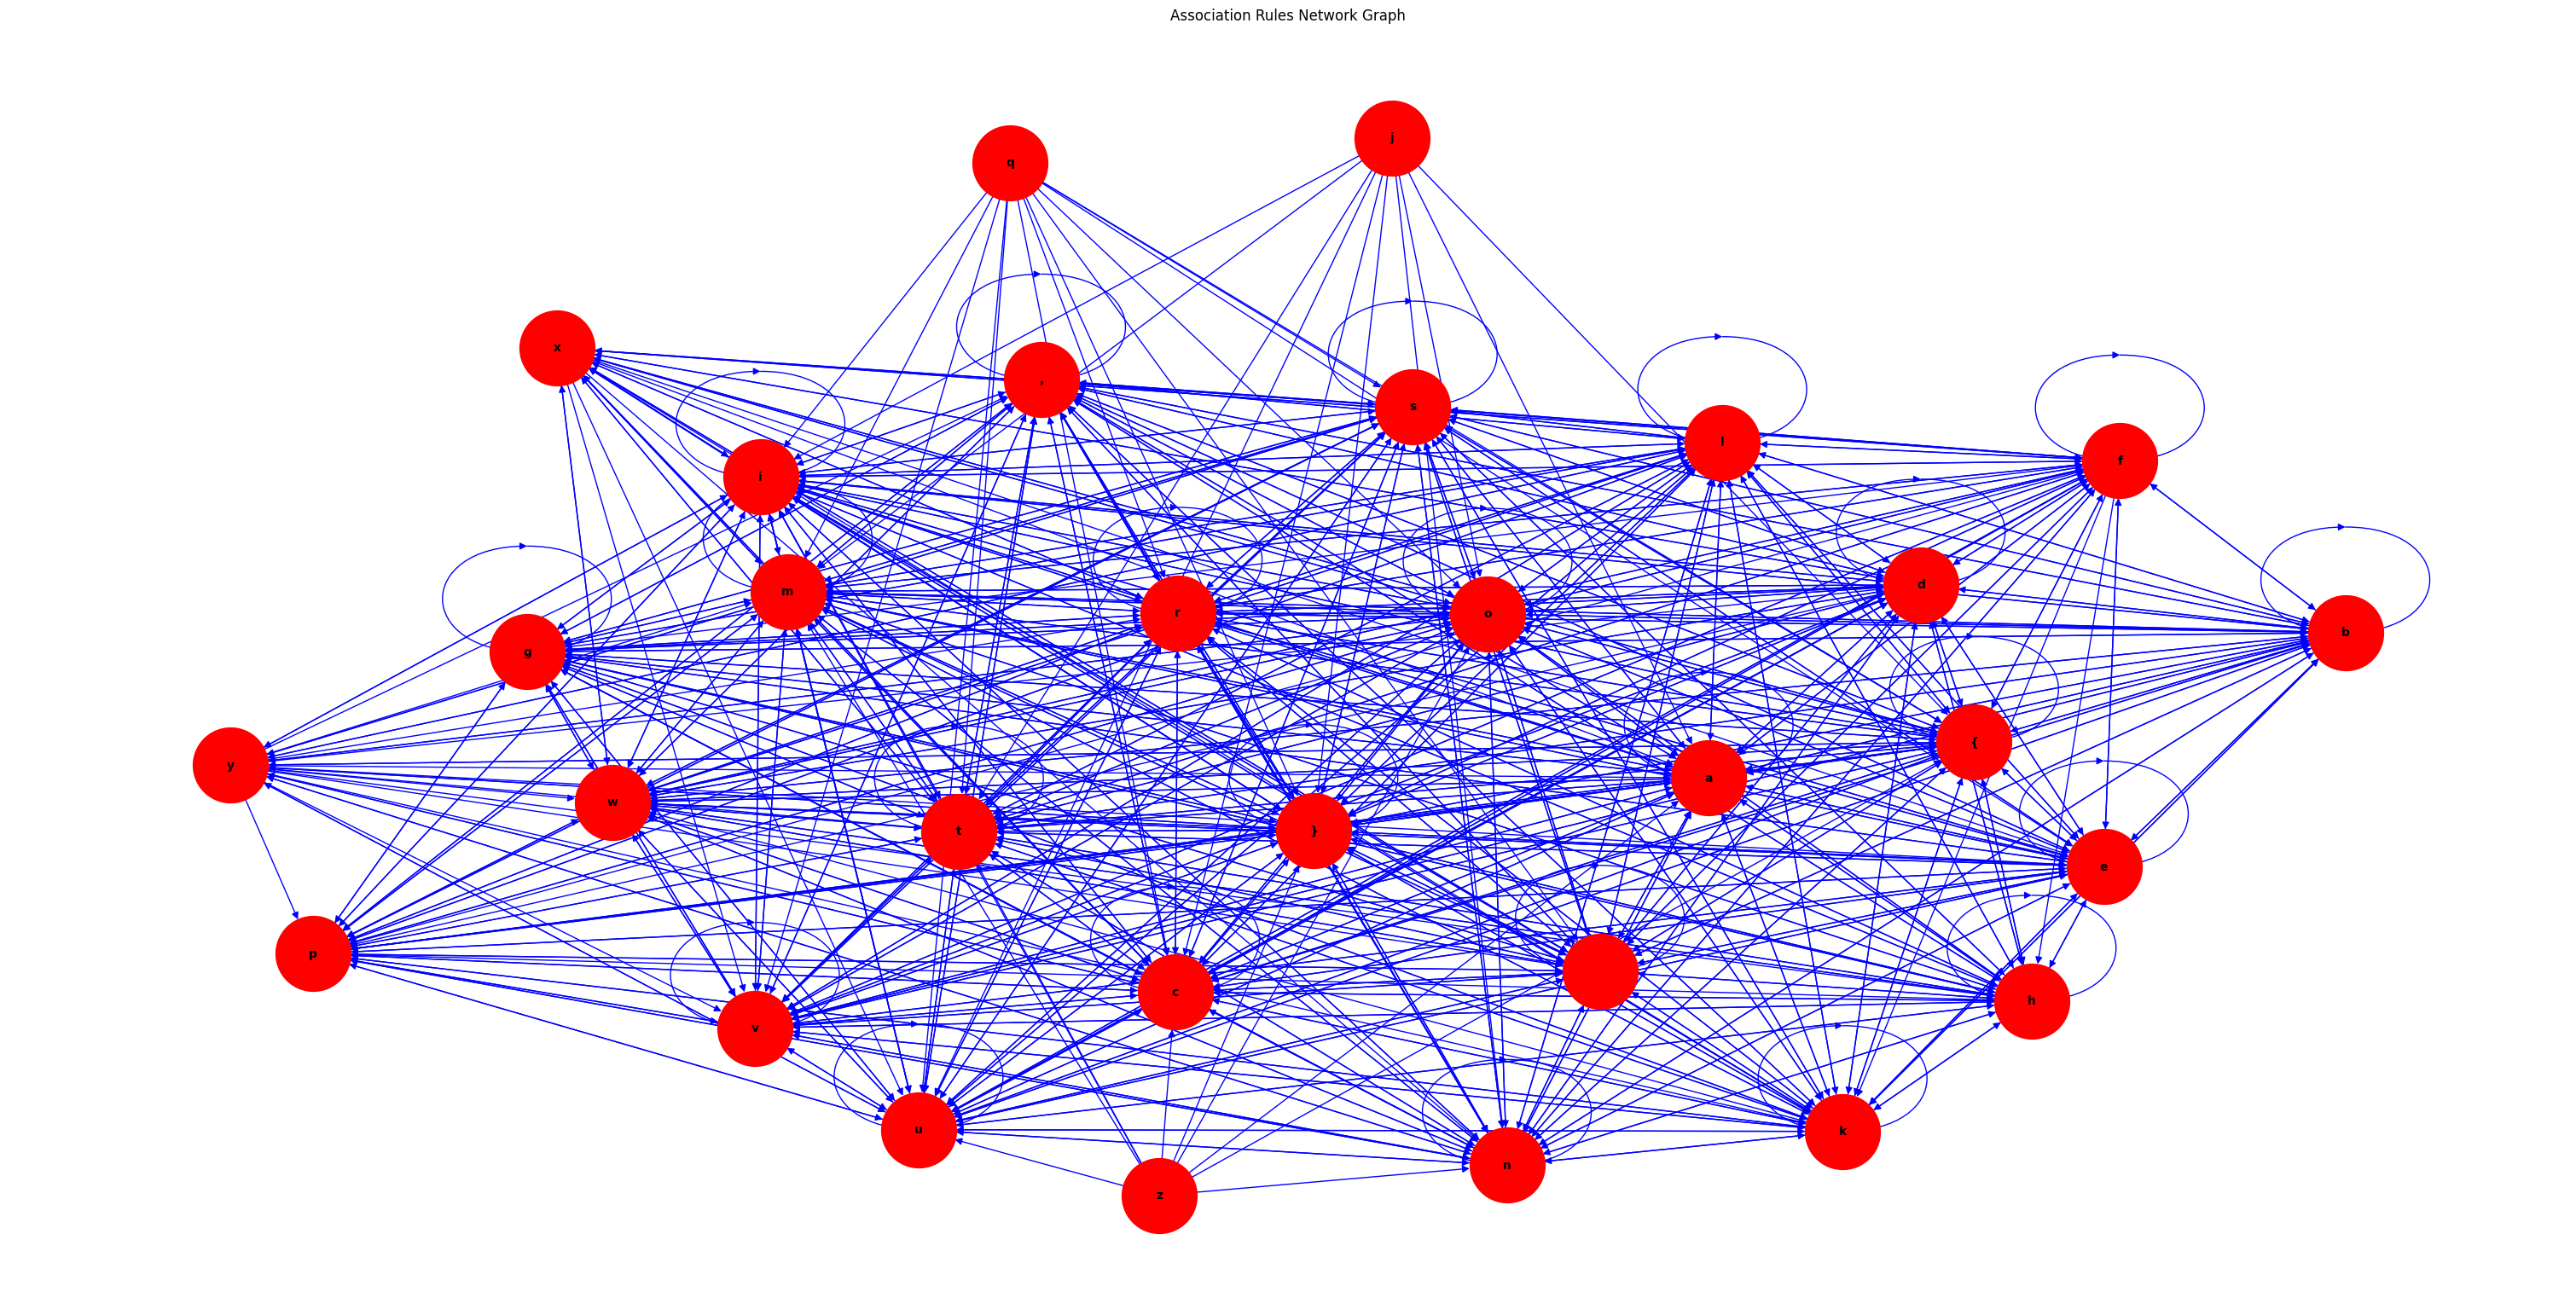

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Helper function to wrap text
def wrap_text(text, width=10):
    return '\n'.join(text[i:i+width] for i in range(0, len(text), width))

# Create a directed graph
G = nx.DiGraph()

# Add edges
for _, row in rules_df.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(wrap_text(antecedent), wrap_text(consequent))

# Draw the graph
pos = nx.spring_layout(G, k=3, iterations=50)
plt.figure(figsize=(30, 15))
nx.draw(G, pos, with_labels=True, node_size=4000, node_color='red', font_size=10, font_weight='bold', arrowsize=12, edge_color='blue')
plt.title("Association Rules Network Graph")
plt.show()


In [20]:
from google.colab import files

# Convert frozensets to strings
frequent_itemsets_apriori['itemsets'] = frequent_itemsets_apriori['itemsets'].apply(lambda x: '{' + ', '.join(list(x)) + '}')
rules_df['antecedents'] = rules_df['antecedents'].apply(lambda x: '{' + ', '.join(list(x)) + '}')
rules_df['consequents'] = rules_df['consequents'].apply(lambda x: '{' + ', '.join(list(x)) + '}')

csv_file_path = '/content/frequent_itemsets_Apriori.csv'
frequent_itemsets_apriori.to_csv(csv_file_path, index=False)
rules_df.to_csv('/content/Association_rules_Apriori.csv', index=False)

# Download the CSV files
files.download(csv_file_path)
files.download('/content/Association_rules_Apriori.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


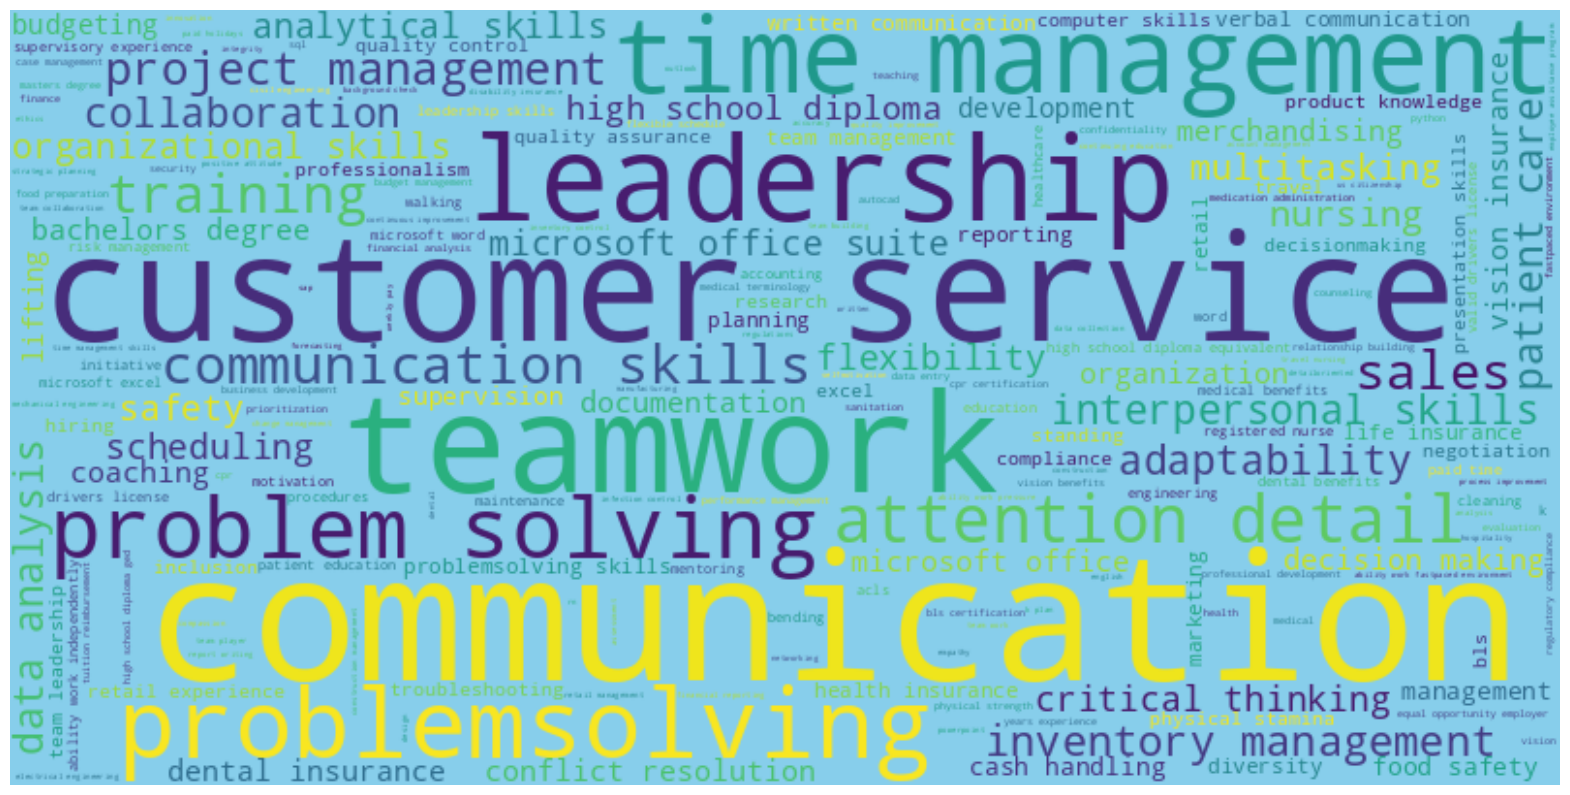

In [27]:
from wordcloud import WordCloud

frequent_itemsets_apriori_df = pd.read_csv(csv_file_path)

# Extract word counts
word_counts = {}
for _, row in frequent_itemsets_apriori_df.iterrows():
    itemset = row['itemsets'].strip('{}').split(', ')
    count = row['count']
    for item in itemset:
        if item in word_counts:
            word_counts[item] += count
        else:
            word_counts[item] = count


wordcloud = WordCloud(width=800, height=400, background_color='skyblue').generate_from_frequencies(word_counts)

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()